# 01. Conversion Rate

### Conversion Rate
We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). Your project is to: 
- Predict conversion rate 
- Come up with recommendations for the product team and the marketing team to improve conversion rate

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./data/conversion_data.csv")
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## 1. EDA

In [3]:
print(f"ndata: {df.shape[0]}")

ndata: 316200


In [4]:
print("There is no missing value")
df.isna().sum()

There is no missing value


country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

### 1-1. Country
Users come from: 
1. US (56.3%) 
2. China (24.2%). 
3. UK (15.3%) 
4. Germany (4.1%)

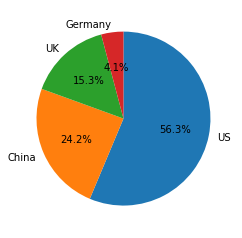

In [5]:
fig1, ax1 = plt.subplots()
data = df["country"].value_counts()

ax1.pie(data, labels=data.index, autopct='%1.1f%%', 
        counterclock=False, startangle=90,  textprops={'color':"black"})
ax1.axis() 
plt.show()

### 1-2. Age
- Most of users age are 20~40
- There are 2 outliers (>100y/o) we need to deal with.

min 17 max: 123


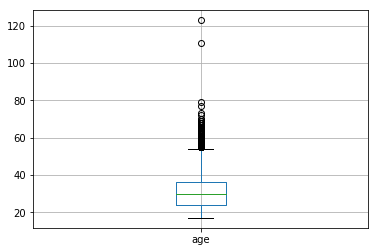

In [6]:
df.boxplot(["age"])
print("min", df["age"].min(), "max:", df["age"].max())

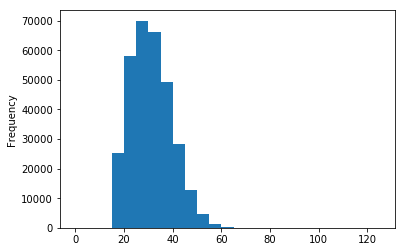

In [7]:
df["age"].plot.hist(bins=np.arange(0,130,5))

### 1-3. Users
- New user (68.5%) vs. Old user (31.5%)

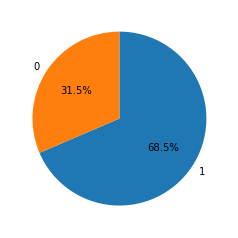

In [8]:
fig1, ax1 = plt.subplots()
data = df["new_user"].value_counts()
ax1.pie(data, labels=data.index, autopct='%1.1f%%', 
        counterclock=False, startangle=90,  textprops={'color':"black"})
ax1.axis() 
plt.show()

### 1-4. Source
- top1 one source is SEO, almost half of user (49.0%) come from this source. The top2 source is Ads (28.1%). Top3 is Direct (22.9)%%.

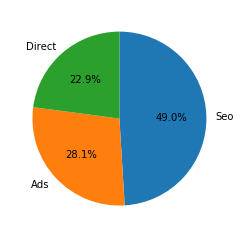

In [9]:
fig1, ax1 = plt.subplots()
data = df["source"].value_counts()
ax1.pie(data, labels=data.index, autopct='%1.1f%%', 
        counterclock=False, startangle=90,  textprops={'color':"black"})
ax1.axis() 
plt.show()

### 1-5. Total Pages Visited
- The dist. of total_pages_visited is positive skewed distribution.

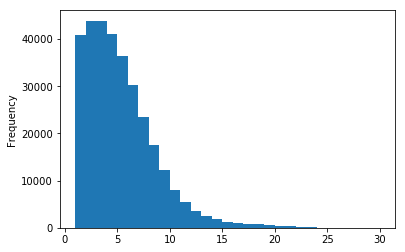

In [10]:
df["total_pages_visited"].plot.hist(bins=np.arange(1,max(df["total_pages_visited"])+2,1))

### 1-6. Converted
- Conversion rate is 3.2%. Our dataset is **extremely imbalanced dataset**.

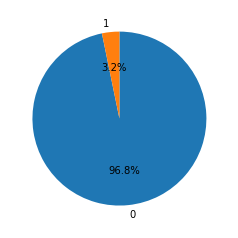

In [11]:
fig1, ax1 = plt.subplots()
data = df["converted"].value_counts()
ax1.pie(data, labels=data.index, autopct='%1.1f%%', 
        counterclock=False, startangle=90,  textprops={'color':"black"})
ax1.axis() 
plt.show()

## 2. Predict Conversion Rate

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

In [13]:
one_hot_col = ["country", "source"]
clean_df = df.loc[df["age"]<100]
one_hot = pd.get_dummies(clean_df[one_hot_col])
data_df = clean_df.drop(one_hot_col, axis=1)
data_df = data_df.join(one_hot)
data_df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


In [14]:
X=data_df.drop(["converted"], axis=1)
y=data_df["converted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 2-1 Built Xgboost Model

In [15]:
import xgboost
import shap

In [16]:
xgb = xgboost.XGBClassifier(seed=100)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=100, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### 2-2 Model Performance
- **Model is not overfitting.** Tree-based models tend to overfit data. Our model is not overfitting by comparing training dataset and testing dataset,.
- **Model perform quit well!** Because our data is imbalanced, we evaluate model performance based on **precision (84%), recall (69%), and pr_auc (83%)**

In [17]:
y_pred = xgb.predict(X_train)
acc = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
print(f"train acc: {acc:.2f} precision:{precision:.2f} recall: {recall:.2f}")
y_pred = xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"test acc: {acc:.2f} precision:{precision:.2f} recall: {recall:.2f}")

train acc: 0.99 precision:0.86 recall: 0.70
test acc: 0.99 precision:0.84 recall: 0.69


In [18]:
y_prob = xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

In [19]:
from sklearn.metrics import auc
auc_precision_recall = auc(recall, precision)
print(f"pr_auc: {auc_precision_recall:.2f}")

pr_auc: 0.83


## 3. Explain the model (shapley value)

In [20]:
explainer = shap.TreeExplainer(xgb, X_train)
shap_values = explainer(X_train)

100%|===================| 252788/252958 [09:40<00:00]       

### 3-1 Generally, the most influential features are:

- total_pages_visited: total_pages_visited ↑, converted ↑
- country_China: if user is from China, converted ↓ 
- age: age ↓, converted ↑
- new_user: if user is new, converted ↓

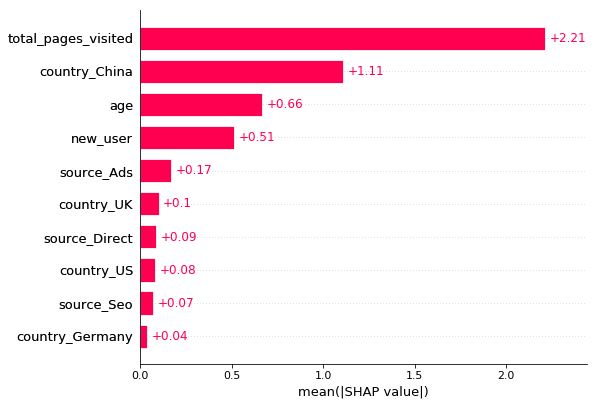

In [21]:
shap.plots.bar(shap_values)

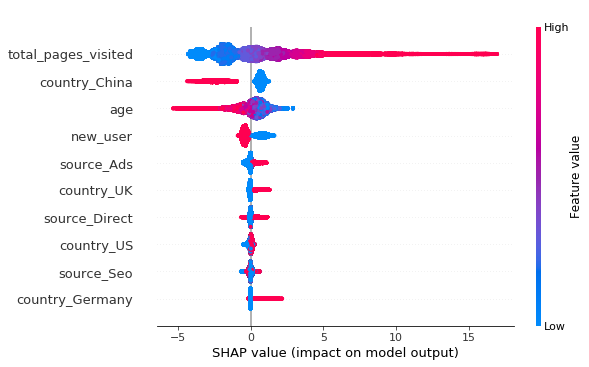

In [22]:
shap.plots.beeswarm(shap_values)

### 3-2 Let’s dive into each feature!

### Top1: total pages visited
- When total_pages_visited <= 4, users tend to not purchase. The relationship between total_pages_visited and conversion is linear. Conversion increase when total_pages_visited increase.
- **There is a data leaky problem**.

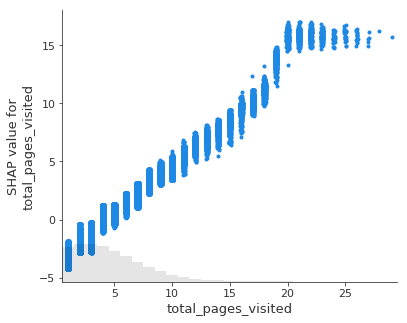

In [23]:
shap.plots.scatter(shap_values[:,"total_pages_visited"])

### Top2: country China
- Conversion from China user are very low.
- Conversion rate are significantly different among all coutries.

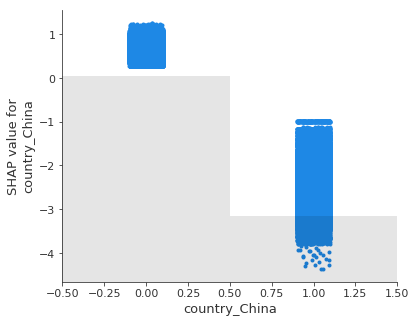

In [24]:
shap.plots.scatter(shap_values[:,"country_China"])

In [25]:
print(f"【avg. conversion rate】")
print(f"{y_train.mean():.2f}")
print("------------------")
print("【train data】")
print(X_train.join(y_train)[["country_China", "converted"]].groupby("country_China").mean())
print("------------------")
print("【all data】")
print(data_df[["country_China", "converted"]].groupby("country_China").mean())

【avg. conversion rate】
0.03
------------------
【train data】
               converted
country_China           
0               0.042132
1               0.001408
------------------
【all data】
               converted
country_China           
0               0.042138
1               0.001332


In [26]:
from scipy.stats import chi2_contingency
from itertools import combinations

In [27]:
# transform to contingency table
country_contingency = pd.crosstab(index=clean_df["country"],columns=clean_df["converted"])

In [28]:
chi2, p, dof, ex = chi2_contingency(country_contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")
all_combinations = list(combinations(country_contingency.index, 2))
print("Significance results:")
for comb in all_combinations:    
    # subset df into a dataframe containing only the pair "comb"    
    new_df = country_contingency[(country_contingency.index == comb[0]) | (country_contingency.index == comb[1])]    
    # running chi2 test    
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)    
    if p<0.05/len(country_contingency.index): #Bonferroni correction        
        sig="*"    
    else:        
        sig=""    
    print(f"Chi2 result for pair {comb} p-value: {p}{sig}")

Omnibus test (p-value): 0.0000
Significance results:
Chi2 result for pair ('China', 'Germany') p-value: 0.0*
Chi2 result for pair ('China', 'UK') p-value: 0.0*
Chi2 result for pair ('China', 'US') p-value: 0.0*
Chi2 result for pair ('Germany', 'UK') p-value: 1.1986730098115515e-05*
Chi2 result for pair ('Germany', 'US') p-value: 3.2658374732742763e-44*
Chi2 result for pair ('UK', 'US') p-value: 3.6065477977271655e-48*


In [29]:
country_contingency["conversion_rate"]=country_contingency[1]/(country_contingency[0]+country_contingency[1])
country_contingency["conversion_rate"].sort_values(ascending=False)

country
Germany    0.062428
UK         0.052612
US         0.037801
China      0.001332
Name: conversion_rate, dtype: float64

### Top3: Age
- The relationship b/w Age and conversion is a U-shaped. Users under 25y/o have the highest conversion. The is a huge drop in 50~60y/o, people who are 50~60y/o tend to drop out without purchasing. Then, people who older then 60 seem like to buy things.

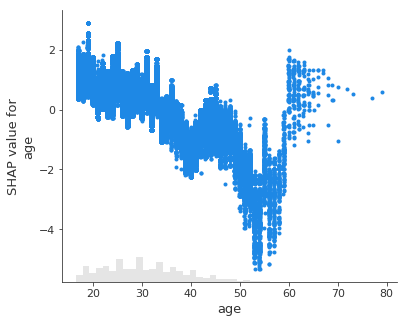

In [30]:
shap.plots.scatter(shap_values[:,"age"])

### Top4: new user
- old users have higher conversion then new user

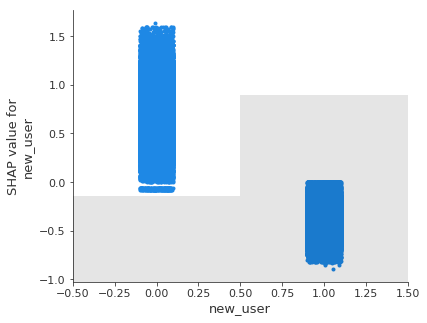

In [31]:
shap.plots.scatter(shap_values[:,"new_user"])

In [32]:
print(f"【avg. conversion rate】")
print(f"{y_train.mean():.2f}")
print("------------------")
print("【train data】")
print(X_train.join(y_train)[["new_user", "converted"]].groupby("new_user").mean())
print("------------------")
print("【all data】")
print(data_df[["new_user", "converted"]].groupby("new_user").mean())

【avg. conversion rate】
0.03
------------------
【train data】
          converted
new_user           
0          0.072219
1          0.014013
------------------
【all data】
          converted
new_user           
0          0.071983
1          0.014021


### Other: Source Analysis
- **Conversion rate: Ads ≈ Seo > Direct** according to Chi-sqaure test

In [33]:
# transform to contingency table
source_contingency = pd.crosstab(index=clean_df["source"],columns=clean_df["converted"])

In [34]:
chi2, p, dof, ex = chi2_contingency(source_contingency, correction=True)
print(f"Omnibus test (p-value): {p:.4f}")

all_combinations = list(combinations(source_contingency.index, 2))
print("Significance results:")
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = source_contingency[(source_contingency.index == comb[0]) | (source_contingency.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
    if p<0.05/len(source_contingency.index):
        sig="*"
    else:
        sig=""
    print(f"Chi2 result for pair {comb}: p-value: {p}{sig}")

Omnibus test (p-value): 0.0000
Significance results:
Chi2 result for pair ('Ads', 'Direct'): p-value: 6.452039996688699e-13*
Chi2 result for pair ('Ads', 'Seo'): p-value: 0.03648148340406828
Chi2 result for pair ('Direct', 'Seo'): p-value: 1.8120435281147074e-09*


In [37]:
source_contingency["conversion_rate"]=source_contingency[1]/(source_contingency[0]+source_contingency[1])
source_contingency["conversion_rate"].sort_values(ascending=False)

source
Ads       0.034472
Seo       0.032888
Direct    0.028169
Name: conversion_rate, dtype: float64

### 3-2 What did we find and What’s our recommendation?

1. total_pages_visited
    - total_pages_visited ≤ 4 has low conversion rate: 
    
    → This might because users can’t find the item they’re interested. It might because our **item recommendation system performance is not good enough** or our **UI design might not friendly enough**.  
    
    → **Action**: To find the root cause, we could **calculate ads CTR** to evaluate our item recommendation system. or evaluate user journey by **tracking the pages they visited** and **page view time**.
    - total_pages_visited ↑, converted ↑: Assume the engagement (# of total_pages_visited) could increase conversion, product team should make user to engege the app/website. (e.g: notification)


2. User from China
    - Chinese user is the secound largest segment but they have the lowest conversion rate (China: 0.001, overall avg. is 0.03). To increase the conversion rate of this segment could largely benefit our business.
    - We strongly suggest product team to **check if there is any problem of the product in China**. e.g: poor translation of app/website, or payment method, or unique e-commerce policy in China etc. To find the root cause, we need more data to support our hypothesis. For example, drop rate in each page (do the funnel analysis).
    - We also strongly suggest marketing team **do more research on China’s market and users**. e.g: competitive product analysis (淘寶), the preference of Chinese users.


3. Age:
    - For marketing team, **we need to approach more users who under 25y/o**. This segment has higher conversion rate. Increase the under 25y/o users will increase our overall conversion rate and revenue.
    - We need to **do some research on why 50~60y/o** are not interested in our items. (or They might don’t know how to use e-commerce system?)
    
4. New user
    - New users have lower conversion rate. **We should remarkting/retargeting the new users**.